In [1]:
import pandas as pd
import numpy as np
import glob, os, functools
from ete3 import NCBITaxa

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!which R

/Users/xcamuj/miniforge3/envs/singlecell2/bin/R


In [3]:
import sys
sys.executable

'/Users/xcamuj/miniforge3/envs/singlecell2/bin/python'

In [4]:
import matplotlib as mpl

mpl.rcParams["svg.fonttype"] = "path"   # <-- makes text outlines (font-safe)
mpl.rcParams["pdf.fonttype"] = 42       # <-- embeds TrueType fonts in PDF (also safe)
mpl.rcParams["ps.fonttype"] = 42


In [5]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="taxid .* was translated into .*",
    category=UserWarning,
)

In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./")

import run_modelling_cleaned as rm


In [7]:
# Load accession taxid map (blast.accession)

ia = pd.read_table(
    "blast/blast.accession",
    index_col=0,
    names=["name", "length", "taxid"],
)

# clean accession index
ia = ia.loc[~ia.index.isna()].copy()
ia.index = ia.index.astype(str)
ia = ia[~ia.index.duplicated(keep="first")]

# normalize taxid to the first component before ';'
ia["taxid1"] = ia["taxid"].astype(str).str.split(";").str[0]
ia = ia[ia["taxid1"].str.fullmatch(r"\d+")]
ia["taxid1"] = ia["taxid1"].astype(int)

print("blast.accession rows:", ia.shape[0])

/var/folders/5h/7wnszww95pj5tsfn3dz_fklh0000gn/T/ipykernel_90346/3553288983.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ia = pd.read_table(


blast.accession rows: 1962798


# Build cm

In [111]:
DOMAINS = ["bacteria", "archaea", "viruses"]
RANKS = ["species", "genus", "family", "order", "class", "phylum"]

domain_results = {}

for DOMAIN in DOMAINS:
    counts_taxid, meta, use_files = rm.build_counts_for_domain(DOMAIN, ia)

    print(f"\n=== {DOMAIN} ===")
    print("Files used:", len(use_files))
    print("Taxid matrix:", counts_taxid.shape)
    print(meta["group"].value_counts())

    # save taxid-level
    counts_taxid.to_csv(f"just_{DOMAIN}_counts.taxid.txt", sep="\t")

    # save ranks
    rank_tables = {}
    for rank in RANKS:
        xr = rm.collapse_to_rank(counts_taxid, rank)
        xr.to_csv(f"just_{DOMAIN}_counts_{rank}.txt", sep="\t")
        rank_tables[rank] = xr
        print(rank, xr.shape)

    domain_results[DOMAIN] = {
        "counts_taxid": counts_taxid,
        "meta": meta,
        "rank_tables": rank_tables
    }



=== bacteria ===
Files used: 55
Taxid matrix: (144013, 55)
group
plasma    41
ntc        8
water      6
Name: count, dtype: int64
species (137066, 55)
genus (3785, 55)
family (765, 55)
order (296, 55)
class (125, 55)
phylum (99, 55)

=== archaea ===
Files used: 55
Taxid matrix: (1719, 55)
group
plasma    41
ntc        8
water      6
Name: count, dtype: int64
species (1561, 55)
genus (166, 55)
family (52, 55)
order (33, 55)
class (20, 55)
phylum (11, 55)

=== viruses ===
Files used: 55
Taxid matrix: (2983, 55)
group
plasma    41
ntc        8
water      6
Name: count, dtype: int64
species (2373, 55)
genus (722, 55)
family (125, 55)
order (48, 55)
class (32, 55)
phylum (16, 55)


# Focus bacteria + genera

In [112]:
DOMAIN = "bacteria"
rank = "genus"

counts = domain_results[DOMAIN]["rank_tables"][rank]
meta = domain_results[DOMAIN]["meta"]

In [113]:
counts

,SAMPLE_100008_1,SAMPLE_100008_2,SAMPLE_100008_3,SAMPLE_100137_1,SAMPLE_100137_2,SAMPLE_100137_3,SAMPLE_100177_1,SAMPLE_100177_2,SAMPLE_100177_3,SAMPLE_100200_2,...,SAMPLE_NTC_5,SAMPLE_NTC_6,SAMPLE_NTC_7,SAMPLE_NTC_8,SAMPLE_water1_1,SAMPLE_water2_1,SAMPLE_water3_1,SAMPLE_water4_1,SAMPLE_water5_1,SAMPLE_water6_1
Azorhizobium,222.0,540.5,3114.5,130.5,265.0,3874.0,984.5,99.0,2649.5,430.0,...,11.0,13.0,13.0,11.0,439.5,2637.5,10.5,1098.0,666.5,1794.5
Cellvibrio,4716.0,5658.0,22869.5,767.0,2794.5,45625.5,8244.5,499.0,21834.0,3207.5,...,93.5,72.5,119.5,94.0,4673.5,36018.0,67.5,7301.0,9308.0,15676.5
Dictyoglomus,43.0,167.0,712.0,18.0,80.5,1293.5,360.0,16.0,578.0,76.5,...,3.0,3.0,3.0,3.0,90.0,716.5,1.0,94.5,307.0,146.0
Methylophilus,777.5,2174.0,9349.0,369.5,1093.5,14166.0,3909.0,197.5,7098.0,1532.0,...,34.5,44.5,66.0,46.0,1555.5,11241.0,31.0,2887.5,3419.5,4548.0
Pelobacter,28.0,109.5,300.5,24.0,59.0,694.5,205.5,12.0,288.5,69.0,...,0.0,1.5,0.0,3.0,92.5,545.0,0.0,154.0,100.5,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Neopararhizobium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tullyiplasma,0.0,0.0,9.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,118.5,0.0,0.0
Pseudocoprococcus,11.5,38.5,247.0,9.0,33.0,362.5,160.5,106.0,358.5,64.0,...,0.0,1.0,2.5,0.0,45.0,166.0,0.5,1102.0,54.0,217.0
Indolivaga,0.0,6.5,0.0,0.0,4.0,5.0,12.0,0.0,20.5,0.5,...,0.0,0.0,0.0,0.5,14.5,0.0,0.5,27.5,41.5,0.0


# edgeR modelling

In [12]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(edgeR)")

ro.r("""
read_counts_df <- function(x) {
  y <- DGEList(counts=x, genes=rownames(x))
  keep <- rowSums(cpm(y) > 5) >= 10
  y <- y[keep,, keep.lib.sizes=FALSE]
  y <- calcNormFactors(y)
  return(y)
}

run_de <- function(y, design) {
  y <- estimateDisp(y, design)
  fit <- glmQLFit(y, design)
  return(fit)
}
""")

R callback write-console: Loading required package: limma
  


# plasma vs water

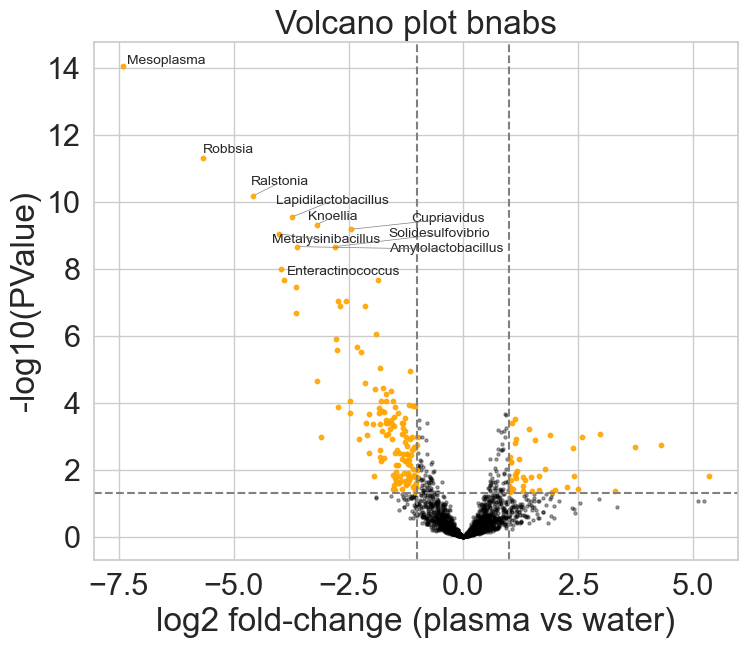

In [402]:
res_bg, logcpm, meta_pw = rm.edger_plasma_vs_water(counts, meta)
a, _ = rm.volcano_plot_fdr(res_bg)

a.savefig('volcano_water.pdf')

In [115]:
res_bg

,genes,logFC,logCPM,F,PValue,FDR
Mesoplasma,Mesoplasma,-7.408255,8.988581,162.375571,4.438030e-18,8.800613e-15
Robbsia,Robbsia,-5.662195,7.438161,113.869599,4.862587e-15,4.821255e-12
Ralstonia,Ralstonia,-4.576759,14.575936,102.836804,1.006474e-13,6.652792e-11
Lapidilactobacillus,Lapidilactobacillus,-3.739154,6.122937,87.092388,5.801074e-13,2.875882e-10
Knoellia,Knoellia,-3.191423,6.935034,85.750122,1.209403e-12,4.796492e-10
...,...,...,...,...,...,...
Algoriphagus,Algoriphagus,-0.001783,8.252367,0.000032,9.955209e-01,9.975331e-01
Methylarcula,Methylarcula,0.001425,4.180101,0.000012,9.971943e-01,9.982692e-01
Savagea,Savagea,0.001166,3.598694,0.000011,9.974106e-01,9.982692e-01
Abiotrophia,Abiotrophia,0.001240,6.263507,0.000008,9.977658e-01,9.982692e-01


In [116]:
meta

,group
SAMPLE_100008_1,plasma
SAMPLE_100008_2,plasma
SAMPLE_100008_3,plasma
SAMPLE_100137_1,plasma
SAMPLE_100137_2,plasma
SAMPLE_100137_3,plasma
SAMPLE_100177_1,plasma
SAMPLE_100177_2,plasma
SAMPLE_100177_3,plasma
SAMPLE_100200_2,plasma


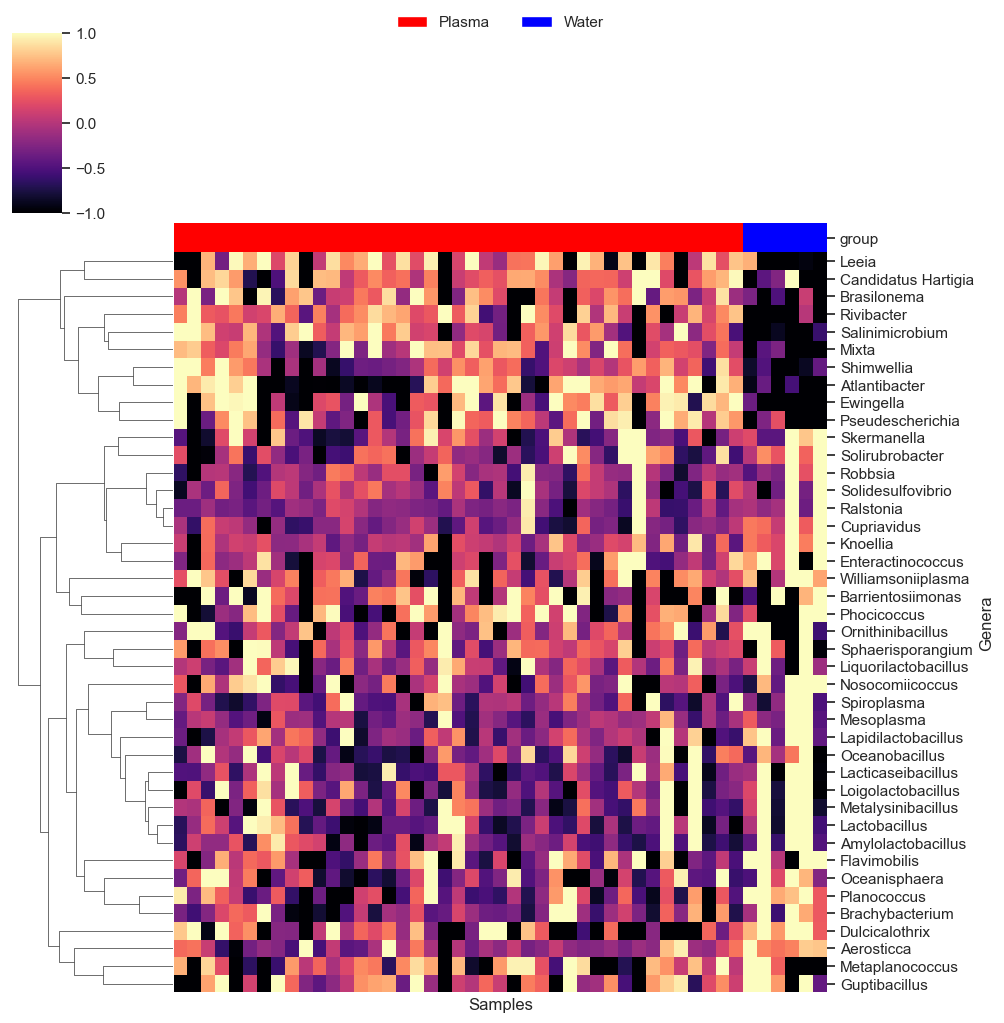

In [18]:

res_bg, logcpm, meta_pw = rm.edger_plasma_vs_water(counts, meta)

rm.clustermap_hits(logcpm, meta_pw, res_bg, min_abs_logfc=2, fdr_thr=0.05, cmap="magma")


# Within plasma - bnab y vs n

In [117]:
DOMAIN = "bacteria"
rank = "genus"
counts = domain_results[DOMAIN]["rank_tables"][rank]
meta = domain_results[DOMAIN]["meta"]

design_df = pd.read_table("edgeR_design.txt", index_col=0)

res_bnabs, logcpm_bnabs, d_plasma = rm.edger_bnabs_plasma(counts, meta, design_df, bNAbs_ref=None)
res_bnabs.head()


,genes,logFC,logCPM,F,PValue,FDR
Paraclostridium,Paraclostridium,2.479870,8.902743,30.261789,0.000002,0.002659
Limosilactobacillus,Limosilactobacillus,-3.780505,11.788602,28.379647,0.000003,0.002659
Shimwellia,Shimwellia,2.912842,6.386954,27.421610,0.000005,0.002659
Caldibacillus,Caldibacillus,-2.373125,10.546858,26.936516,0.000005,0.002659
Tepidiphilus,Tepidiphilus,-2.136803,7.496506,25.393559,0.000008,0.003147


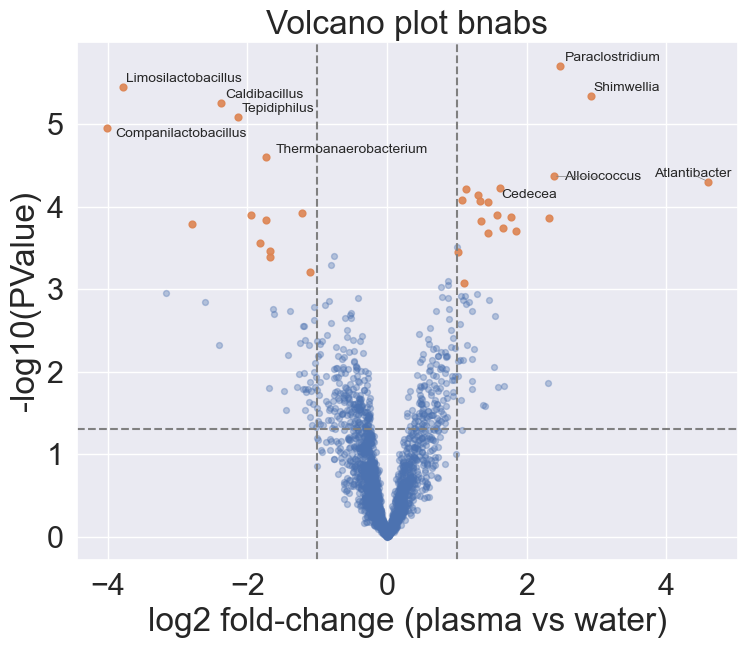

In [118]:
rm.volcano_plot(res_bnabs)

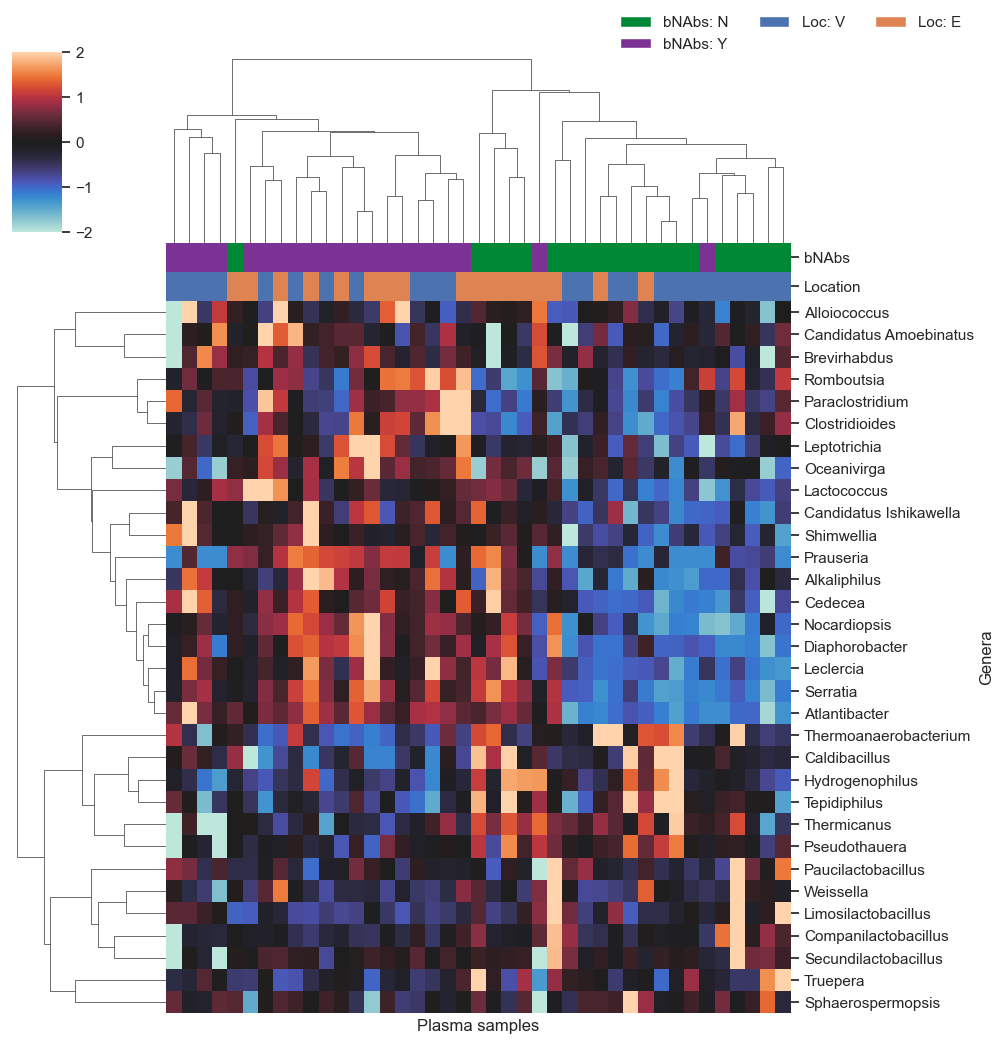

In [119]:
rm.clustermap_bnabs(logcpm_bnabs, d_plasma, res_bnabs, min_abs_logfc=1, fdr_thr=0.05)


# Highlight families in volcano

In [381]:

# build this once per domain/rank
genus_table = domain_results[DOMAIN]["rank_tables"]["genus"]
genus_name_to_taxid = rm.build_name_to_taxid_map(genus_table.index, rank="genus")

In [382]:
# Add family annotations to a result table indexed by genus name.
res_bg_fam    = rm.add_family_to_res_from_map(res_bg, genus_name_to_taxid)
res_bnabs_fam = rm.add_family_to_res_from_map(res_bnabs, genus_name_to_taxid)


In [384]:
# Use this to make palette for families
shared_palette, top_fams_global = rm.build_shared_family_palette(
    [res_bg_fam, res_bnabs_fam],
    fdr_thr=0.05,
    lfc_thr=1.0,
    top_n_families=12,
    base_palette="tab20",
    other_color="wheat",
    unknown_color="silver"
)

res_bg_fam2    = rm.apply_family_plot_bucket(res_bg_fam, top_fams_global)
res_bnabs_fam2 = rm.apply_family_plot_bucket(res_bnabs_fam, top_fams_global)

In [385]:
res_bnabs_fam2 

,genes,logFC,logCPM,F,PValue,FDR,genus_taxid,family_taxid,family,family_plot
Paraclostridium,Paraclostridium,2.479870,8.902743,30.261789,0.000002,0.002659,1849822,186804.0,Peptostreptococcaceae,Other
Limosilactobacillus,Limosilactobacillus,-3.780505,11.788602,28.379647,0.000003,0.002659,2742598,33958.0,Lactobacillaceae,Lactobacillaceae
Shimwellia,Shimwellia,2.912842,6.386954,27.421610,0.000005,0.002659,1335483,543.0,Enterobacteriaceae,Enterobacteriaceae
Caldibacillus,Caldibacillus,-2.373125,10.546858,26.936516,0.000005,0.002659,1276290,186817.0,Bacillaceae,Bacillaceae
Tepidiphilus,Tepidiphilus,-2.136803,7.496506,25.393559,0.000008,0.003147,203470,206349.0,Hydrogenophilaceae,Other
...,...,...,...,...,...,...,...,...,...,...
Dehalogenimonas,Dehalogenimonas,-0.001308,5.089610,0.000048,0.994478,0.996528,670486,1202464.0,Dehalococcoidaceae,Other
Dolosigranulum,Dolosigranulum,0.001792,5.093461,0.000034,0.995350,0.996888,29393,186828.0,Carnobacteriaceae,Other
Nocardioides,Nocardioides,0.000784,13.571141,0.000010,0.997469,0.998011,1839,85015.0,Nocardioidaceae,Other
Defluviitoga,Defluviitoga,-0.001484,2.061150,0.000010,0.997498,0.998011,1511648,1643949.0,Petrotogaceae,Other


In [386]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./")

import run_modelling_cleaned as rm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


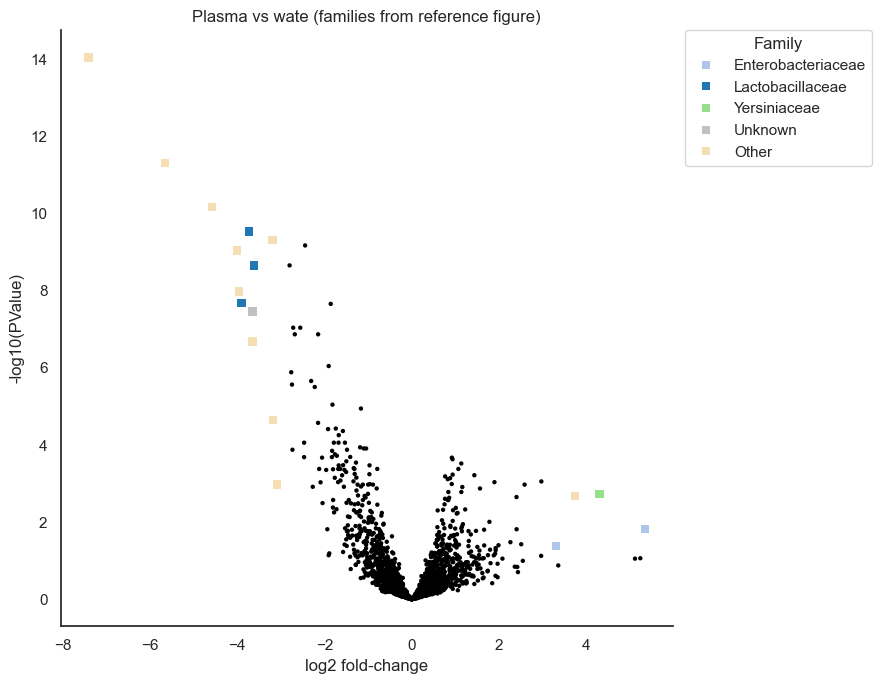

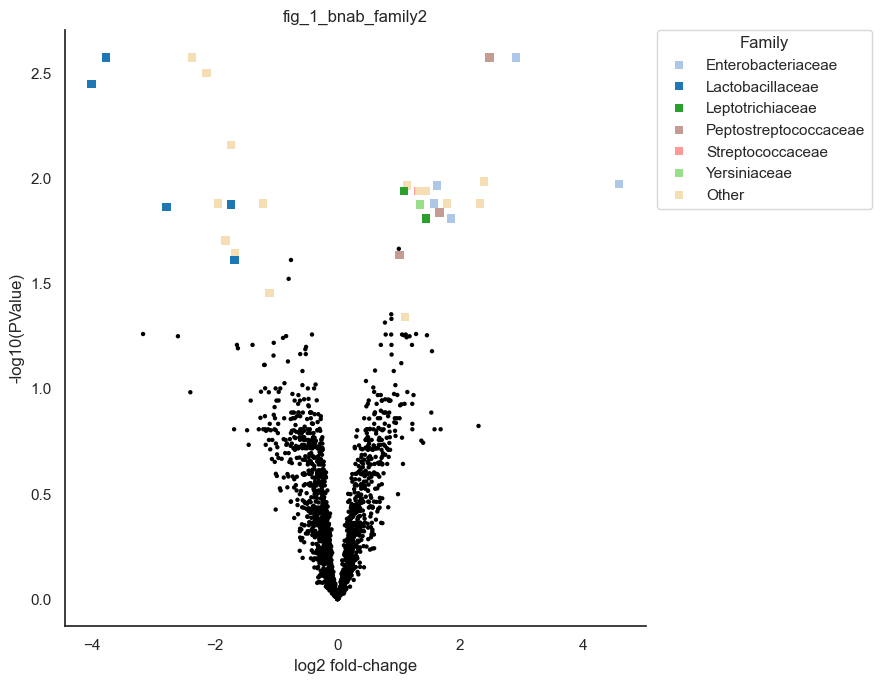

In [388]:
# families to highlight from paper: https://doi.org/10.1186/s12915-014-0087-z
families_to_highlight = [
    # original list
    "Planctomycetaceae",
    "Pseudomonadaceae",
    "Moraxellaceae",
    "Enterobacteriaceae",
    "Flavobacteriaceae",
    "Polyangiaceae",
    "Bacteriovoracaceae",
    "Ruminococcaceae",
    "Lachnospiraceae",
    "unclassified Chlamydiales",
    "Neisseriaceae",
    "unclassified Burkholderiales",
    "Oxalobacteraceae",
    "Burkholderiaceae",
    "Sphingobacteriaceae",
    "Chitinophagaceae",
    "Cytophagaceae",
    "Bacteroidaceae",
    "Streptococcaceae",
    "Lactobacillaceae",
    "Enterococcaceae",
    "Aerococcaceae",
    "Staphylococcaceae",
    "Paenibacillaceae",
    "Bacillaceae",
    "Sphingomonadaceae",
    "Rhodobacteraceae",
    "Xanthobacteraceae",
    "Phyllobacteriaceae",
    "Methylobacteriaceae",
    "Bradyrhizobiaceae",
    "Caulobacteraceae",
    "Coriobacteriaceae",
    "Bifidobacteriaceae",
    "Propionibacteriaceae",
    "Micrococcaceae",
    "Microbacteriaceae",
    "Corynebacteriaceae",
    "Acidobacteriaceae",

    # human-associated families
    "Peptostreptococcaceae",
    "Leptotrichiaceae",
    "Veillonellaceae",
    "Clostridiaceae",
    "Erysipelotrichaceae",
    #"Yersiniaceae",
    "Carnobacteriaceae",
    #"Thermoanaerobacteraceae",
    "Nocardiaceae",
    "Pseudonocardiaceae",
]

families_to_highlight = [	"Enterobacteriaceae",
		"Peptostreptococcaceae",
		"Leptotrichiaceae","Yersiniaceae",
		"Streptococcaceae",
		"Lactobacillaceae"]



#  want the categories beforehand to build palette safely)
def set_family_plot_from_highlight(res, highlight_families):
    df = res.copy()
    df["family_plot"] = np.where(df["family"].isin(highlight_families), df["family"], "Other")
    df.loc[df["family"].eq("Unknown"), "family_plot"] = "Unknown"
    return df

res_bg_fam2_h = set_family_plot_from_highlight(res_bg_fam2, families_to_highlight)
res_bnabs_fam2_h = set_family_plot_from_highlight(res_bnabs_fam2, families_to_highlight)

# ensure palette covers EVERYTHING that might show up
families_present = set(res_bg_fam2["family"].unique()) | set(res_bnabs_fam2["family"].unique())
shared_palette = rm.ensure_palette_has_families(shared_palette, families_present)

rm.volcano_plot_family_fixed2(
    res_bg_fam2,
    palette=shared_palette,
    title="Plasma vs wate (families from reference figure)",
    mode="fdr_lfc",
    p_thr=1e-8,
    lfc_thr=3.0,
    highlight_families=families_to_highlight
)

rm.volcano_plot_family_fixed2(
    res_bnabs_fam2,
    palette=shared_palette,
    title="fig_1_bnab_family2",
    mode="fdr_lfc",
    p_thr=1e-3,
    lfc_thr=1.0,
    highlight_families=families_to_highlight
)


In [366]:
res_bnabs_fam2[(res_bnabs_fam2['PValue']<1e-3) &(res_bnabs_fam2['logFC']>1)]['family'].value_counts()

family
Enterobacteriaceae       5
Peptostreptococcaceae    3
Leptotrichiaceae         2
Carnobacteriaceae        1
Comamonadaceae           1
Streptococcaceae         1
Natronincolaceae         1
Nocardiopsidaceae        1
Flavobacteriaceae        1
Pseudonocardiaceae       1
Yersiniaceae             1
Paracoccaceae            1
Name: count, dtype: int64

In [365]:
tm = res_bnabs_fam2[(res_bnabs_fam2['PValue']<1e-3) &(np.abs(res_bnabs_fam2['logFC'])>1)]['family'].value_counts()

In [271]:
res_bnabs_fam2[(res_bnabs_fam2['PValue']<1e-3) &(res_bnabs_fam2['logFC']>1)]['family'].value_counts()

family
Enterobacteriaceae       5
Peptostreptococcaceae    3
Leptotrichiaceae         2
Carnobacteriaceae        1
Comamonadaceae           1
Streptococcaceae         1
Natronincolaceae         1
Nocardiopsidaceae        1
Flavobacteriaceae        1
Pseudonocardiaceae       1
Yersiniaceae             1
Paracoccaceae            1
Name: count, dtype: int64

In [278]:


import matplotlib.pyplot as plt

names = tm.index.tolist()
names= ['Enterobacteriaceae','Peptostreptococcaceae',\
 'Leptotrichiaceae','Yersiniaceae','Lactobacillaceae',\
 'Streptococcaceae']
names= names+['Other']
cmap = plt.get_cmap("tab10")
joan_palette = {name: cmap(i) for i, name in enumerate(names)}


In [279]:
res_bnabs_fam2['family_plot'] = res_bnabs_fam2['family_plot'].where(
    res_bnabs_fam2['family_plot'].isin(names),
    'Other'
)

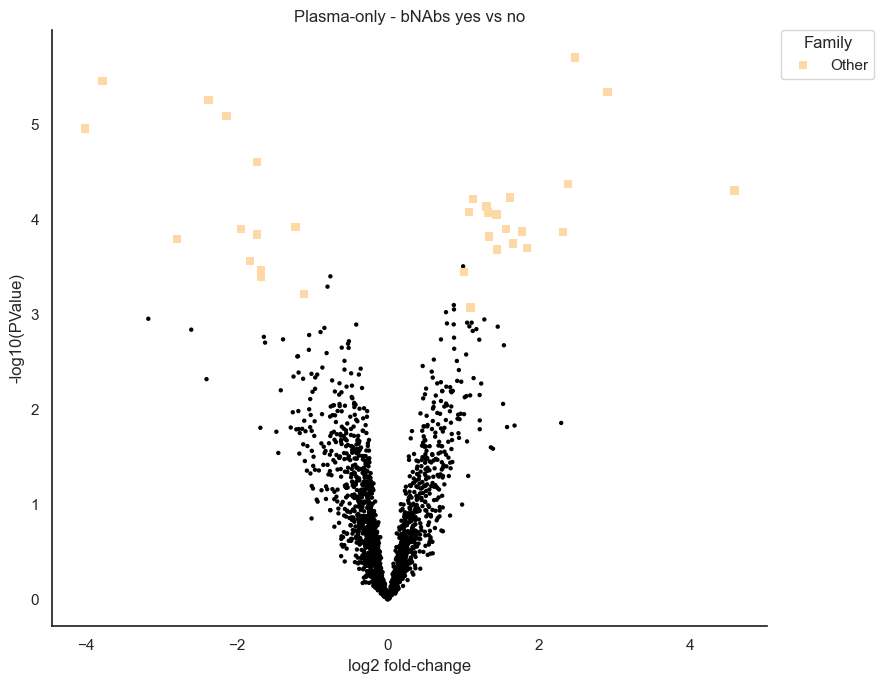

In [305]:





rm.volcano_plot_family_fixed(
    res_bnabs_fam2,
    palette=joan_palette2,
    title="Plasma-only - bNAbs yes vs no",
    mode="p_fc",
    p_thr=1e-3,
    lfc_thr=1.0,
    highlight_families=names
)

In [414]:
# Add family annotations to a result table indexed by genus name.
res_bg_fam    = rm.add_phylum_to_res_from_map(res_bg, genus_name_to_taxid)
res_bnabs_fam = rm.add_phylum_to_res_from_map(res_bnabs, genus_name_to_taxid)

res_bg_fam['family'] = res_bg_fam ['phylum']
res_bnabs_fam['family'] = res_bnabs_fam['phylum']


In [415]:
res_bnabs_fam.head(20)['family'].value_counts()

family
Bacillota         9
Pseudomonadota    7
Actinomycetota    2
Fusobacteriota    1
Bacteroidota      1
Name: count, dtype: int64

In [416]:
res_bg_fam.head(20)['family'].value_counts()

family
Bacillota                  9
Pseudomonadota             4
Mycoplasmatota             3
Actinomycetota             3
Thermodesulfobacteriota    1
Name: count, dtype: int64

In [417]:
# Use this to make palette for families
shared_palette, top_fams_global = rm.build_shared_family_palette(
    [res_bg_fam, res_bnabs_fam],
    fdr_thr=0.05,
    lfc_thr=1.0,
    top_n_families=12,
    base_palette="tab20",
    other_color="wheat",
    unknown_color="silver"
)

res_bg_fam2    = rm.apply_family_plot_bucket(res_bg_fam, top_fams_global)
res_bnabs_fam2 = rm.apply_family_plot_bucket(res_bnabs_fam, top_fams_global)

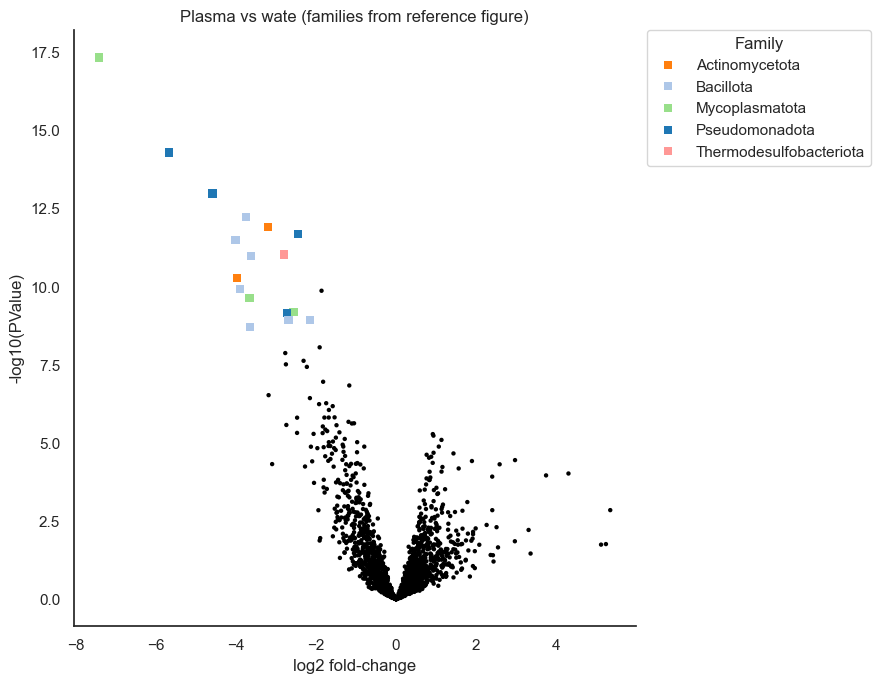

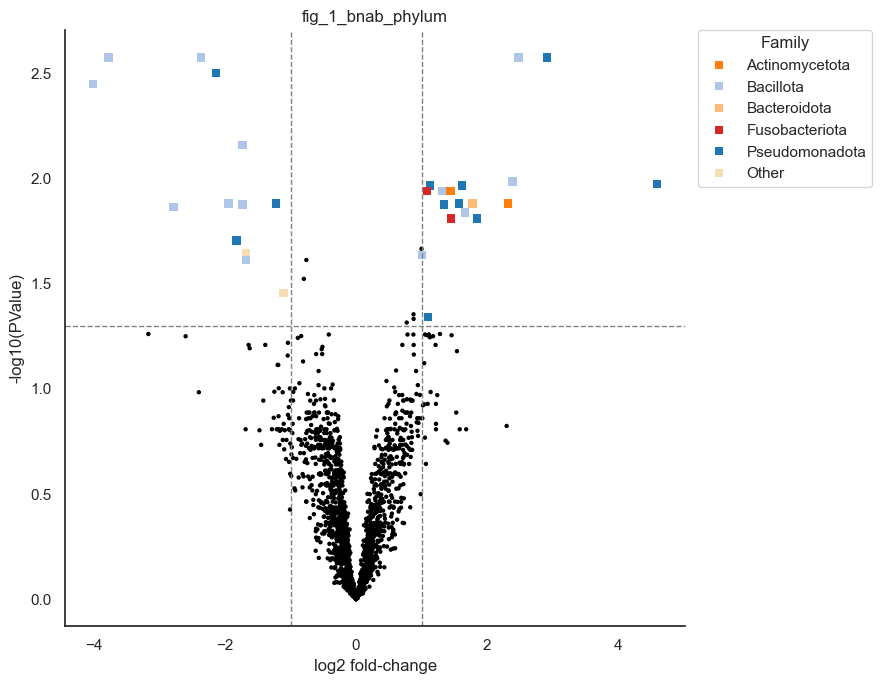

In [424]:


families_to_highlight = ["Bacillota",
"Pseudomonadota",
"Actinomycetota",
"Fusobacteriota",
"Bacteroidota",
"Mycoplasmatota",
"Thermodesulfobacteriota"]
                        
#  want the categories beforehand to build palette safely)
def set_family_plot_from_highlight(res, highlight_families):
    df = res.copy()
    df["family_plot"] = np.where(df["family"].isin(highlight_families), df["family"], "Other")
    df.loc[df["family"].eq("Unknown"), "family_plot"] = "Unknown"
    return df

res_bg_fam2_h = set_family_plot_from_highlight(res_bg_fam2, families_to_highlight)
res_bnabs_fam2_h = set_family_plot_from_highlight(res_bnabs_fam2, families_to_highlight)

# ensure palette covers EVERYTHING that might show up
families_present = set(res_bg_fam2["family"].unique()) | set(res_bnabs_fam2["family"].unique())
shared_palette = rm.ensure_palette_has_families(shared_palette, families_present)

rm.volcano_plot_family_fixed(
    res_bg_fam2,
    palette=shared_palette,
    title="Plasma vs wate (families from reference figure)",
    mode="p_fc",
    p_thr=1e-8,
    lfc_thr=2.0,
    highlight_families=families_to_highlight
)

rm.volcano_plot_family_fixed2(
    res_bnabs_fam2,
    palette=shared_palette,
    title="fig_1_bnab_phylum",
    mode="fdr_lfc",
    fdr_thr=5e-2,
    lfc_thr=1.0,
    show_cutoffs=True,
    highlight_families=families_to_highlight
)

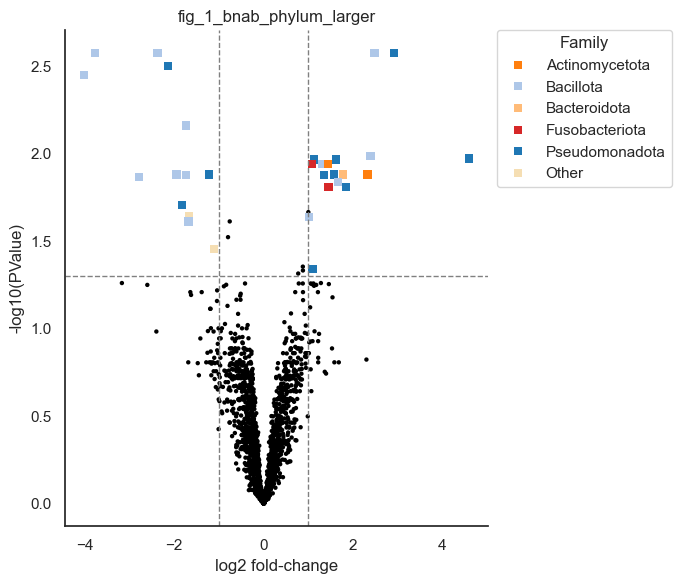

In [429]:


families_to_highlight = ["Bacillota",
"Pseudomonadota",
"Actinomycetota",
"Fusobacteriota",
"Bacteroidota",
"Mycoplasmatota",
"Thermodesulfobacteriota"]
                        
#  want the categories beforehand to build palette safely)
def set_family_plot_from_highlight(res, highlight_families):
    df = res.copy()
    df["family_plot"] = np.where(df["family"].isin(highlight_families), df["family"], "Other")
    df.loc[df["family"].eq("Unknown"), "family_plot"] = "Unknown"
    return df

res_bg_fam2_h = set_family_plot_from_highlight(res_bg_fam2, families_to_highlight)
res_bnabs_fam2_h = set_family_plot_from_highlight(res_bnabs_fam2, families_to_highlight)

# ensure palette covers EVERYTHING that might show up
families_present = set(res_bg_fam2["family"].unique()) | set(res_bnabs_fam2["family"].unique())
shared_palette = rm.ensure_palette_has_families(shared_palette, families_present)


rm.volcano_plot_family_fixed2(
    res_bnabs_fam2,
    palette=shared_palette,
    title="fig_1_bnab_phylum_larger",
    mode="fdr_lfc",
    fdr_thr=5e-2,
    lfc_thr=1.0,
    show_cutoffs=True,
    figsize=(7, 6),
    highlight_families=families_to_highlight
)

Class level attempt

In [408]:
# Add family annotations to a result table indexed by genus name.
res_bg_fam    = rm.add_class_to_res_from_map(res_bg, genus_name_to_taxid)
res_bnabs_fam = rm.add_class_to_res_from_map(res_bnabs, genus_name_to_taxid)

res_bg_fam['family'] = res_bg_fam ['class']
res_bnabs_fam['family'] = res_bnabs_fam['class']


In [409]:
res_bnabs_fam.head(20)['class'].value_counts()

class
Bacilli                6
Gammaproteobacteria    4
Clostridia             3
Betaproteobacteria     2
Actinomycetes          2
Hydrogenophilia        1
Fusobacteriia          1
Flavobacteriia         1
Name: count, dtype: int64

In [437]:
res_bnabs_fam[(res_bnabs_fam.FDR<0.05) & (res_bnabs_fam.logFC>1)].describe()

,logFC,logCPM,F,PValue,FDR,genus_taxid,phylum_taxid
count,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000
mean,1.808469,7.799639,18.946426,0.000151,0.013722,7.085315e+05,25509.578947
std,0.857932,2.908782,4.005342,0.000187,0.008849,8.211827e+05,62652.714861
min,1.008752,2.362302,12.718461,0.000002,0.002659,6.130000e+02,976.000000
25%,1.320110,5.625482,16.871931,0.000060,0.010816,4.707150e+04,1224.000000
50%,1.570669,8.694703,18.730867,0.000089,0.011479,2.163870e+05,1239.000000
75%,2.086246,10.112782,19.797107,0.000165,0.013911,1.663041e+06,1239.000000
max,4.594310,11.737000,30.261789,0.000843,0.045532,1.903434e+06,201174.000000


In [410]:
res_bg_fam.head(20)['class'].value_counts()

class
Bacilli                9
Mollicutes             3
Betaproteobacteria     3
Actinomycetes          3
Desulfovibrionia       1
Gammaproteobacteria    1
Name: count, dtype: int64

In [411]:
# Use this to make palette for families
shared_palette, top_fams_global = rm.build_shared_family_palette(
    [res_bg_fam, res_bnabs_fam],
    fdr_thr=0.05,
    lfc_thr=1.0,
    top_n_families=12,
    base_palette="tab20",
    other_color="wheat",
    unknown_color="silver"
)

res_bg_fam2    = rm.apply_family_plot_bucket(res_bg_fam, top_fams_global)
res_bnabs_fam2 = rm.apply_family_plot_bucket(res_bnabs_fam, top_fams_global)

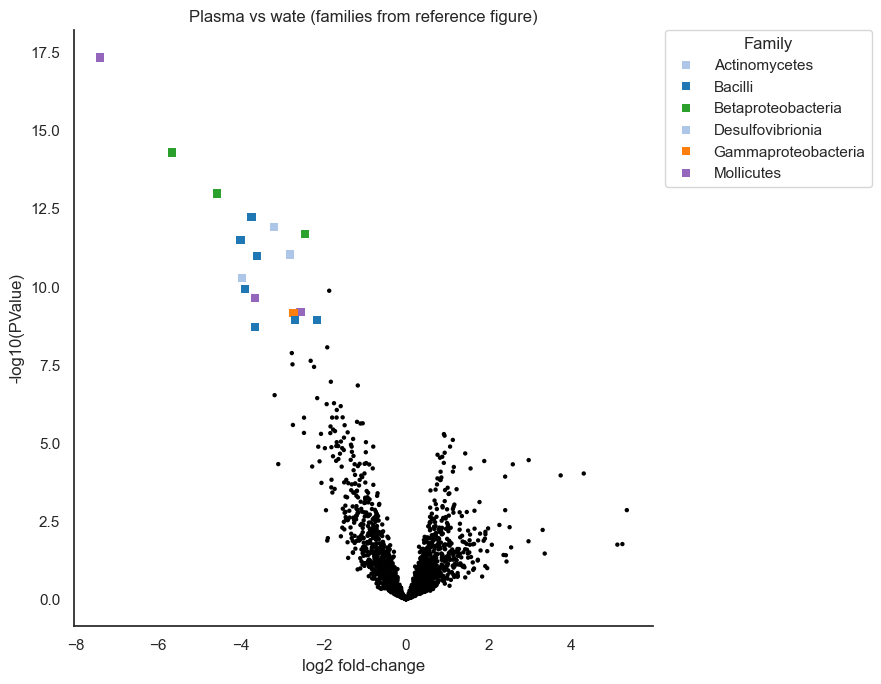

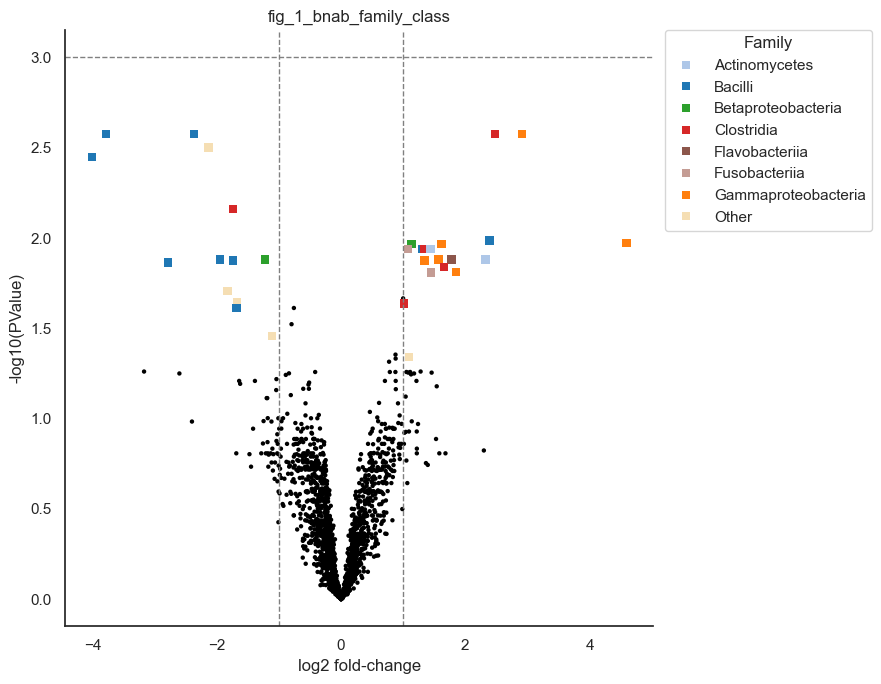

In [413]:


families_to_highlight = ['Bacilli', 'Gammaproteobacteria', 'Clostridia', 'Betaproteobacteria',
       'Actinomycetes',  'Fusobacteriia', 'Flavobacteriia', 'Mollicutes', 
       'Desulfovibrionia']
                        
#  want the categories beforehand to build palette safely)
def set_family_plot_from_highlight(res, highlight_families):
    df = res.copy()
    df["family_plot"] = np.where(df["family"].isin(highlight_families), df["family"], "Other")
    df.loc[df["family"].eq("Unknown"), "family_plot"] = "Unknown"
    return df

res_bg_fam2_h = set_family_plot_from_highlight(res_bg_fam2, families_to_highlight)
res_bnabs_fam2_h = set_family_plot_from_highlight(res_bnabs_fam2, families_to_highlight)

# ensure palette covers EVERYTHING that might show up
families_present = set(res_bg_fam2["family"].unique()) | set(res_bnabs_fam2["family"].unique())
shared_palette = rm.ensure_palette_has_families(shared_palette, families_present)

rm.volcano_plot_family_fixed(
    res_bg_fam2,
    palette=shared_palette,
    title="Plasma vs wate (families from reference figure)",
    mode="p_fc",
    p_thr=1e-8,
    lfc_thr=2.0,
    highlight_families=families_to_highlight
)

rm.volcano_plot_family_fixed2(
    res_bnabs_fam2,
    palette=shared_palette,
    title="fig_1_bnab_family_class",
    mode="p_fc",
    p_thr=1e-3,
    lfc_thr=1.0,
    show_cutoffs=True,
    highlight_families=families_to_highlight
)